WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε, ν_]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.
Sampling: [y_pred]


Output()

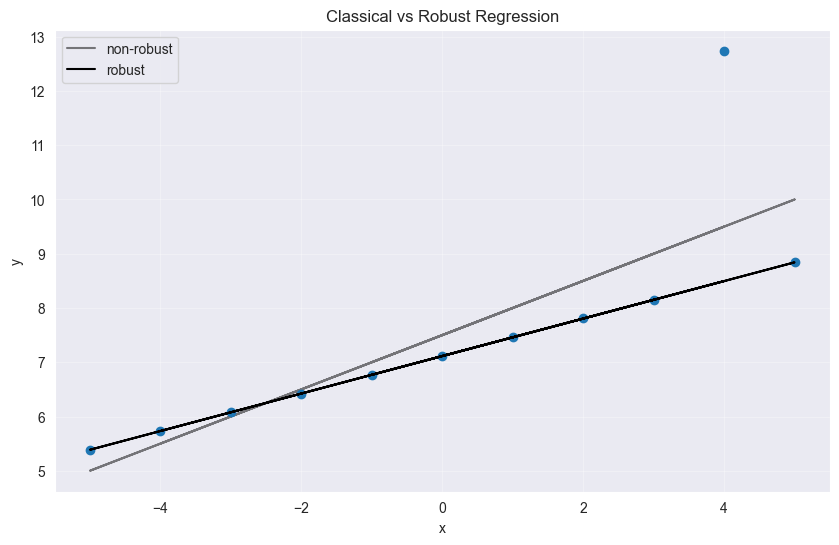

<Figure size 1200x600 with 0 Axes>

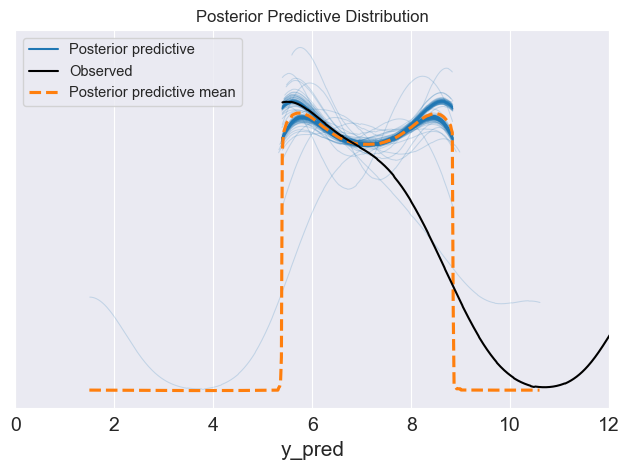

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pymc as pm
import seaborn as sns
import arviz as az
from scipy.stats import linregress

# Create Anscombe's quartet dataset with all four groups
anscombe = pd.DataFrame({
    'group': ['I']*11 + ['II']*11 + ['III']*11 + ['IV']*11,
    'x': [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5] * 4,
    'y': [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68,  # Group I
          9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74,   # Group II
          7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73,  # Group III
          7.91, 8.81, 8.04, 7.93, 8.89, 8.19, 7.53, 8.24, 8.01, 7.20, 6.85]   # Group IV
})

# Extract dataset III
x_3 = anscombe[anscombe.group == 'III']['x'].values
y_3 = anscombe[anscombe.group == 'III']['y'].values

# Center x_3
x_3 = x_3 - x_3.mean()

# Classical linear regression
beta_c, alpha_c = linregress(x_3, y_3)[:2]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot classical regression line
plt.plot(x_3, alpha_c + beta_c * x_3, 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')

# Bayesian robust regression with PyMC
with pm.Model() as model_t:
    # Priors
    α = pm.Normal('α', mu=y_3.mean(), sigma=1)
    β = pm.Normal('β', mu=0, sigma=1)
    ε = pm.HalfNormal('ε', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)
    
    # Likelihood
    y_pred = pm.StudentT('y_pred', mu=α + β * x_3,
                        sigma=ε, nu=ν, observed=y_3)
    
    # Sample from the posterior
    idata_t = pm.sample(2000, return_inferencedata=True)
    
    # Generate posterior predictive samples
    posterior_pred = pm.sample_posterior_predictive(idata_t, extend_inferencedata=True)

# Extract posterior means
alpha_m = float(idata_t.posterior['α'].mean())
beta_m = float(idata_t.posterior['β'].mean())

# Plot robust regression line
plt.plot(x_3, alpha_m + beta_m * x_3, 'k', label='robust')

# Customize plot
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=2)
plt.title('Classical vs Robust Regression')
plt.grid(True, alpha=0.3)

# Create posterior predictive plot
plt.figure(figsize=(12, 6))
az.plot_ppc(idata_t, num_pp_samples=200, mean=True)
plt.xlim(0, 12)
plt.title('Posterior Predictive Distribution')

plt.tight_layout()
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, β2, ϵ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, ϵ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β2, ϵ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

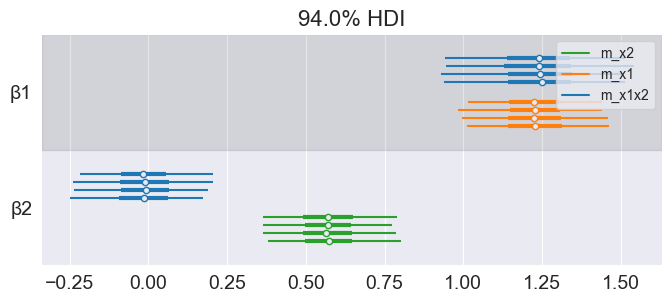

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from scipy.stats import linregress


np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
# x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T


with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sigma=10)
    β1 = pm.Normal('β1', mu=0, sigma=10)
    β2 = pm.Normal('β2', mu=0, sigma=10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    µ = α + β1 * X[:, 0] + β2 * X[:, 1]
    y_pred = pm.Normal('y_pred', mu=µ, sigma=ϵ, observed=y)
    idata_x1x2 = pm.sample(2000, return_inferencedata=True)

with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sigma=10)
    β1 = pm.Normal('β1', mu=0, sigma=10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    µ = α + β1 * X[:, 0]
    y_pred = pm.Normal('y_pred', mu=µ, sigma=ϵ, observed=y)
    idata_x1 = pm.sample(2000, return_inferencedata=True)
    
with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sigma=10)
    β2 = pm.Normal('β2', mu=0, sigma=10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    µ = α + β2 * X[:, 1]
    y_pred = pm.Normal('y_pred', mu=µ, sigma=ϵ, observed=y)
    idata_x2 = pm.sample(2000, return_inferencedata=True)

az.plot_forest([idata_x1x2, idata_x1, idata_x2],
model_names=['m_x1x2', 'm_x1', 'm_x2'],
var_names=['β1', 'β2'],
combined=False, colors='cycle', figsize=(8, 3))
